In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [22]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
# import yaml
# import os

# # Path to the existing vehicles.yaml
# yaml_path = "/kaggle/input/vehicle-detection/Vehicle_Detection/vehicles.yaml"

# # Read existing YAML
# with open(yaml_path, 'r') as file:
#     config = yaml.safe_load(file)

# # Update configuration
# updated_config = {
#     'path': '/kaggle/input/vehicle-detection',
#     'train': 'train/images',
#     'val': 'valid/images',
#     'test': 'test/images',
#     'names': {
#         0: 'Bus',
#         1: 'Truck',
#         2: 'Motorcycle',
#         3: 'Car'
#     }
# }

# # Write updated YAML
# with open('/kaggle/working/vehicles.yaml', 'w') as file:
#     yaml.dump(updated_config, file)

# print("Updated vehicles.yaml created in /kaggle/working/")

In [24]:
# import os

# dataset_path = "/content/Vehicle_Detection"
# classes = os.listdir(dataset_path)
# for cls in classes:
#     cls_path = os.path.join(dataset_path, cls)
#     print(f"{cls}: {len(os.listdir(cls_path))} images")

In [25]:
import yaml

yaml_path = "Vehicle_Detection/vehicles.yaml"

with open(yaml_path, 'r') as file:
    config = yaml.safe_load(file)

print(config)

{'path': '/Vehicle_Detection', 'train': 'train/images', 'val': '/valid/images', 'test': '/test/images', 'names': {0: 'Bus', 1: 'Truck', 2: 'Motorcycle', 3: 'Car'}}


In [26]:
import os

def check_label_files(dataset_path):
    splits = ['train', 'valid', 'test']

    for split in splits:
        labels_dir = os.path.join(dataset_path, split, 'labels')

        print(f"\n{split.upper()} Label Files:")

        # Sample first few label files
        label_files = os.listdir(labels_dir)

        for label_file in label_files[:5]:
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                print(f"File: {label_file}")
                print(f"Content: {f.read().strip()}")

        print(f"Total label files: {len(label_files)}")

# Run the check
dataset_path = "Vehicle_Detection"
check_label_files(dataset_path)


TRAIN Label Files:
File: -------------------------------------------------------------------_Moment-11-_jpg.rf.819fa0654c50430f87e39b3892ff919a.txt
Content: 0 0.48677884615384615 0.7091346153846154 0.71875 0.5528846153846154
File: -------------------------------------------------------------------_Moment-11-_jpg.rf.eb1b8ee93a76957aff8ce2f63ccfa7de.txt
Content: 0 0.5132211538461539 0.29086538461538464 0.71875 0.5528846153846154
File: -------------------------------------------------------------------_Moment-12-_jpg.rf.57b149b9ae686e9a14992f2c0305c9b8.txt
Content: 0 0.5060096153846154 0.4807692307692308 0.9206730769230769 0.9615384615384616
File: -------------------------------------------------------------------_Moment-12-_jpg.rf.673fc8460629df34b2146755e4e451ab.txt
Content: 0 0.4951923076923077 0.5180288461538461 0.9230769230769231 0.9591346153846154
File: -------------------------------------------------------------------_Moment-14-_jpg.rf.405c7f6fcd818be7b3ca9312d84a1b95.txt
Content

In [27]:
import os
import yaml

def check_dataset_integrity(dataset_path):
    yaml_path = os.path.join(dataset_path, 'vehicles.yaml')

    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)

    classes = config['names']
    splits = ['train', 'valid', 'test']

    results = {}

    for split in splits:
        images_dir = os.path.join(dataset_path, split, 'images')
        labels_dir = os.path.join(dataset_path, split, 'labels')

        results[split] = {
            'total_images': 0,
            'class_distribution': {cls: 0 for cls in classes.values()},
            'label_integrity': True
        }

        label_files = os.listdir(labels_dir)

        for label_file in label_files:
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                labels = f.read().strip().split('\n')
                for label in labels:
                    parts = label.split()
                    if parts:  # Ensure label is not empty
                        class_num = int(parts[0])
                        results[split]['class_distribution'][classes[class_num]] += 1

        results[split]['total_images'] = len(label_files)

    return results

# Run the check
dataset_path = "Vehicle_Detection"
integrity_results = check_dataset_integrity(dataset_path)

# Print results
for split, data in integrity_results.items():
    print(f"\n{split.upper()} Dataset:")
    print(f"Total Images: {data['total_images']}")
    print("Class Distribution:", data['class_distribution'])


TRAIN Dataset:
Total Images: 12000
Class Distribution: {'Bus': 4163, 'Truck': 3107, 'Motorcycle': 3348, 'Car': 3320}

VALID Dataset:
Total Images: 2692
Class Distribution: {'Bus': 853, 'Truck': 810, 'Motorcycle': 666, 'Car': 843}

TEST Dataset:
Total Images: 1141
Class Distribution: {'Bus': 438, 'Truck': 412, 'Motorcycle': 96, 'Car': 405}


In [28]:
# !ls /kaggle/input/vehicle-detection/Vehicle_Detection/


In [29]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
import random

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [30]:
# !ls /kaggle/working/

In [31]:
# Define dataset paths
train_images_dir = "Vehicle_Detection/train/images"
train_labels_dir = "Vehicle_Detection/train/labels"
valid_images_dir = "Vehicle_Detection/valid/images"
valid_labels_dir = "Vehicle_Detection/valid/labels"
test_images_dir = "Vehicle_Detection/test/images"
test_labels_dir = "Vehicle_Detection/test/labels"

print("Dataset paths set:")
print(f"  Train images: {train_images_dir}")
print(f"  Train labels: {train_labels_dir}")
print(f"  Validation images: {valid_images_dir}")
print(f"  Validation labels: {valid_labels_dir}")
print(f"  Test images: {test_images_dir}")
print(f"  Test labels: {test_labels_dir}")

# Import necessary libraries
import torchvision.transforms as transforms
from PIL import Image
import torch
import os

# Define VehicleDataset class
class VehicleDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = sorted([file for file in os.listdir(image_dir) if file.endswith(('.jpg', '.png'))])
        self.label_files = sorted([file for file in os.listdir(label_dir) if file.endswith('.txt')])
        self.transform = transform

        assert len(self.image_files) == len(self.label_files), \
            "Mismatch between number of images and labels"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        img = Image.open(img_path).convert("RGB")

        # Load label
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        boxes = []
        classes = []

        try:
            with open(label_path, "r") as f:
                for line in f.readlines():
                    elements = line.strip().split()
                    class_id = int(elements[0])
                    bbox = [float(x) for x in elements[1:]]
                    classes.append(class_id)
                    boxes.append(bbox)
        except Exception as e:
            print(f"Error reading label file: {label_path}, {e}")

        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        classes = torch.tensor(classes, dtype=torch.int64) if classes else torch.zeros((0,), dtype=torch.int64)

        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)

        return img, boxes, classes


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Resize((416, 416))  # Resize all images to 416x416
])

# Instantiate datasets
try:
    train_dataset = VehicleDataset(train_images_dir, train_labels_dir, transform=transform)
    valid_dataset = VehicleDataset(valid_images_dir, valid_labels_dir, transform=transform)
    test_dataset = VehicleDataset(test_images_dir, test_labels_dir, transform=transform)

    print("Datasets instantiated:")
    print(f"  Train dataset size: {len(train_dataset)}")
    print(f"  Validation dataset size: {len(valid_dataset)}")
    print(f"  Test dataset size: {len(test_dataset)}")
except Exception as e:
    print(f"Error instantiating datasets: {e}")


Dataset paths set:
  Train images: Vehicle_Detection/train/images
  Train labels: Vehicle_Detection/train/labels
  Validation images: Vehicle_Detection/valid/images
  Validation labels: Vehicle_Detection/valid/labels
  Test images: Vehicle_Detection/test/images
  Test labels: Vehicle_Detection/test/labels
Datasets instantiated:
  Train dataset size: 12000
  Validation dataset size: 2692
  Test dataset size: 1141


In [32]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 8

# Custom collate function
def custom_collate_fn(batch):
    """
    Custom collate function to handle variable-sized bounding boxes and class labels in batches.
    """
    images = []
    boxes = []
    classes = []

    for img, box, cls in batch:
        images.append(img)
        boxes.append(box)
        classes.append(cls)

    # Stack images into a single tensor
    images = torch.stack(images, dim=0)

    return images, boxes, classes

# Create DataLoaders with custom collate_fn
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=custom_collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    collate_fn=custom_collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    collate_fn=custom_collate_fn
)

print("DataLoaders created:")
print(f"  Train DataLoader: {len(train_loader)} batches")
print(f"  Validation DataLoader: {len(valid_loader)} batches")
print(f"  Test DataLoader: {len(test_loader)} batches")


DataLoaders created:
  Train DataLoader: 1500 batches
  Validation DataLoader: 337 batches
  Test DataLoader: 143 batches


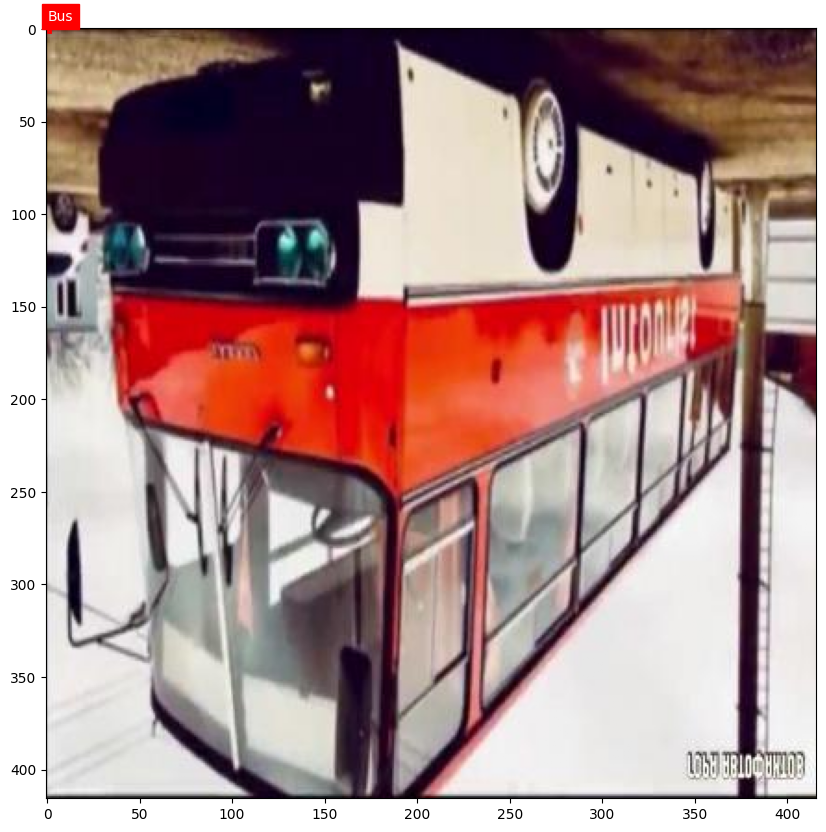

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_sample(img, boxes, classes, class_names):
    img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy array
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img)

    for box, cls in zip(boxes, classes):
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, class_names[cls], color='white', fontsize=10, backgroundcolor='red')

    plt.show()

# Define class names
class_names = ['Bus', 'Truck', 'Motorcycle', 'Car']

# Visualize a sample from the training dataset
sample_img, sample_boxes, sample_classes = train_dataset[9]
visualize_sample(sample_img, sample_boxes, sample_classes, class_names)


In [34]:
# for images, boxes, classes in train_loader:
#     print(f"Type of images: {type(images)}")
#     print(f"Type of boxes: {type(boxes)}")
#     print(f"Type of classes: {type(classes)}")
#     break  # We only need to check one batch


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [36]:
import torch
import torch.nn as nn
import torchvision.models as models

class VehicleDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(VehicleDetectionModel, self).__init__()

        # Use a pre-trained ResNet50 as the backbone
        backbone = models.resnet50(pretrained=True)

        # Remove the last fully connected layer
        self.features = nn.Sequential(*list(backbone.children())[:-2])

        # Bounding box regression head
        self.bbox_head = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 4, kernel_size=1)  # 4 values for [x, y, width, height]
        )

        # Classification head
        self.cls_head = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extract features
        features = self.features(x)

        # Predict bounding boxes
        bbox_pred = self.bbox_head(features)

        # Predict classes
        cls_pred = self.cls_head(features)

        # Reshape bbox predictions to match input batch size
        bbox_pred = bbox_pred.view(bbox_pred.size(0), -1, 4)

        return bbox_pred, cls_pred

In [37]:
# def compute_masked_loss(pred_boxes, pred_classes, padded_boxes, padded_classes, bbox_loss_fn, class_loss_fn):
#     # Create a mask for non-zero boxes
#     box_mask = (padded_boxes.sum(dim=-1) != 0)

#     # Reshape predictions to match padded boxes
#     batch_size, max_objects, _ = padded_boxes.shape

#     # Slice predictions to match padded boxes dimensions
#     masked_pred_boxes = pred_boxes[:batch_size, :max_objects]
#     masked_pred_classes = pred_classes[:batch_size, :max_objects]

#     # Apply mask to true boxes and classes
#     masked_true_boxes = padded_boxes[box_mask]
#     masked_true_classes = padded_classes[box_mask]

#     # Compute bounding box loss only for non-zero entries
#     bbox_loss = bbox_loss_fn(masked_pred_boxes[box_mask], masked_true_boxes)

#     # Compute class loss
#     class_loss = class_loss_fn(
#         masked_pred_classes.view(-1, masked_pred_classes.size(-1)),
#         masked_true_classes.view(-1)
#     )

#     return bbox_loss, class_loss

In [38]:
def safe_compute_loss(pred_boxes, pred_classes, padded_boxes, padded_classes, bbox_loss_fn, class_loss_fn):
    # Ensure predictions are on the same device as targets
    pred_boxes = pred_boxes.to(padded_boxes.device)
    pred_classes = pred_classes.to(padded_classes.device)

    # Create a mask for non-zero boxes
    box_mask = (padded_boxes.sum(dim=-1) != 0)

    # Ensure predictions have compatible shape
    batch_size, max_objects, _ = padded_boxes.shape

    # Slice or pad predictions to match
    if pred_boxes.shape[1] > max_objects:
        pred_boxes = pred_boxes[:, :max_objects]
        pred_classes = pred_classes[:, :max_objects]
    elif pred_boxes.shape[1] < max_objects:
        # Pad predictions if needed
        pad_size = max_objects - pred_boxes.shape[1]
        pred_boxes = torch.nn.functional.pad(pred_boxes, (0, 0, 0, pad_size))
        pred_classes = torch.nn.functional.pad(pred_classes, (0, pad_size))

    # Compute losses with careful device and shape handling
    try:
        # Compute bounding box loss
        bbox_loss = bbox_loss_fn(pred_boxes[box_mask], padded_boxes[box_mask])

        # Compute class loss
        class_loss = class_loss_fn(
            pred_classes.view(-1, pred_classes.size(-1)),
            padded_classes.view(-1)
        )

        return bbox_loss, class_loss
    except RuntimeError as e:
        print(f"Loss computation error: {e}")
        # Return zero losses to allow training to continue
        return torch.tensor(0.0, device=padded_boxes.device), torch.tensor(0.0, device=padded_boxes.device)


In [39]:
import torch

# Check CUDA availability
print("CUDA available:", torch.cuda.is_available())

# Check current device
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "No CUDA")

# List all available GPUs
print("GPU count:", torch.cuda.device_count())

# Detailed GPU information
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

CUDA available: True
Current device: 0
GPU count: 1
GPU Name: NVIDIA GeForce GTX 1650


In [ ]:
# Instantiate the model
num_classes = 4  # 'Bus', 'Truck', 'Motorcycle', 'Car'

torch.cuda.set_device(0)
# Move model to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = VehicleDetectionModel(num_classes=num_classes)
model = model.to(device)

# Define optimizer and loss functions
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
bbox_loss_fn = nn.MSELoss()  # Mean Squared Error for bounding boxes
class_loss_fn = nn.CrossEntropyLoss()  # CrossEntropy for class predictions

accumulation_steps = 4  # Simulate larger batch size without full memory load

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_bbox_loss = 0
    total_class_loss = 0

    print(f"Starting Epoch {epoch+1}/{epochs}...")
    for batch_idx, (images, boxes, classes) in enumerate(train_loader):
        print(f"Processing batch {batch_idx + 1}/{len(train_loader)}...")
        
        # Data preparation
        max_objects = max(len(box) for box in boxes)
        padded_boxes = torch.zeros(len(boxes), max_objects, 4)
        padded_classes = torch.zeros(len(boxes), max_objects, dtype=torch.long)
        for i, box in enumerate(boxes):
            padded_boxes[i, :len(box)] = box
        for i, cls in enumerate(classes):
            padded_classes[i, :len(cls)] = cls
        
        # Move to device
        images, padded_boxes, padded_classes = images.to(device), padded_boxes.to(device), padded_classes.to(device)
        
        # Forward pass
        pred_boxes, pred_classes = model(images)
        bbox_loss, class_loss = safe_compute_loss(pred_boxes, pred_classes, padded_boxes, padded_classes, bbox_loss_fn, class_loss_fn)
        total_loss = bbox_loss + class_loss

        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        total_bbox_loss += bbox_loss.item()
        total_class_loss += class_loss.item()
    
    print(f"Epoch {epoch+1}/{epochs} completed. Avg BBox Loss: {total_bbox_loss/len(train_loader)}, Avg Class Loss: {total_class_loss/len(train_loader)}")


Using device: cuda


d:\Lotus\Projects\NN\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Lotus\Projects\NN\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Epoch 1/5...


In [ ]:
model.eval()
with torch.no_grad():
    total_val_bbox_loss = 0
    total_val_class_loss = 0

    for images, boxes, classes in valid_loader:
        images, boxes, classes = images.to(device), boxes.to(device), classes.to(device)

        pred_boxes, pred_classes = model(images)
        bbox_loss = bbox_loss_fn(pred_boxes, boxes)
        class_loss = class_loss_fn(pred_classes, classes)

        total_val_bbox_loss += bbox_loss.item()
        total_val_class_loss += class_loss.item()

    print(f"Validation - BBox Loss: {total_val_bbox_loss/len(valid_loader)}, Class Loss: {total_val_class_loss/len(valid_loader)}")


In [ ]:
model.eval()
test_results = []

with torch.no_grad():
    for images, boxes, classes in test_loader:
        # Move data to the device
        images, boxes, classes = images.to(device), boxes.to(device), classes.to(device)

        # Get model predictions
        pred_boxes, pred_classes = model(images)

        # Convert predictions and ground truth to CPU (for easier processing)
        pred_boxes = pred_boxes.cpu()
        pred_classes = pred_classes.cpu()
        boxes = boxes.cpu()
        classes = classes.cpu()

        for idx in range(len(images)):
            # Gather individual sample predictions
            pred_boxes_sample = pred_boxes[idx]
            pred_classes_sample = pred_classes[idx
            ]
            true_boxes_sample = boxes[idx]
            true_classes_sample = classes[idx]

            # Save results for later evaluation (e.g., mAP or IoU calculation)
            test_results.append({
                "true_boxes": true_boxes_sample.numpy(),
                "true_classes": true_classes_sample.numpy(),
                "pred_boxes": pred_boxes_sample.numpy(),
                "pred_classes": pred_classes_sample.numpy(),
            })

print("Testing complete. Results saved.")


In [ ]:
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = box1_area + box2_area - intersection
    return intersection / union if union > 0 else 0
